# Event Queue Application Benchmarks

In [19]:
# select measurement file
files = [
    "../output/2024-12-08 17-07-29.json",
    "../output/2024-12-01 20-13-22 storage.json"
]

# plot settings
show_error_bar = False
unit = "ms"

In [20]:
# parse data
import json

raw_data = []
for file_name in files:
    with open(file_name) as file:
        raw_data.extend(json.load(file))

In [21]:
from util.convert import convert_datasets
import pandas as pd

ram = convert_datasets(
    raw_data,
    "Event Queue",
    [("event_queue_ram", "RAM Buffer")],
    [
        "mean",
        "min",
        "max",
        "options.object_size",
        "options.queue_length",
        "options.iterations",
        "options.buffer_size",
        "options.ram_overhead",
        "machine_name",
        "cold_start",
        "repetitions",
    ],
    unwrapped=show_error_bar,
)

storage = convert_datasets(
    raw_data,
    "Event Queue",
    [("event_queue_storage", "Storage")],
    [
        "mean",
        "min",
        "max",
        "options.object_size",
        "options.queue_length",
        "options.iterations",
        "options.buffer_size",
        "options.ram_overhead",
        "machine_name",
        "cold_start",
        "repetitions",
    ],
    unwrapped=show_error_bar,
)
vnvheap = convert_datasets(
    raw_data,
    "Event Queue",
    [("event_queue", "vNV-Heap")],
    [
        "mean",
        "min",
        "max",
        "options.object_size",
        "options.queue_length",
        "options.iterations",
        "options.buffer_size",
        "options.ram_overhead",
        "machine_name",
        "cold_start",
        "repetitions",
    ],
    unwrapped=show_error_bar,
)

dataset = pd.concat([ram, storage, vnvheap])
dataset.head()

,mean,min,max,options.object_size,options.queue_length,options.iterations,options.buffer_size,options.ram_overhead,machine_name,cold_start,repetitions,ticks_per_ms,dataset_type,benchmark_title,benchmark_id
0,9727.3,9727,9728,256,0,10,256.0,16,esp32c3,0,10,16000,Event Queue,RAM Buffer,event_queue_ram
1,9727.5,9727,9728,256,1,10,512.0,16,esp32c3,0,10,16000,Event Queue,RAM Buffer,event_queue_ram
2,9727.5,9727,9728,256,2,10,768.0,16,esp32c3,0,10,16000,Event Queue,RAM Buffer,event_queue_ram
3,9727.5,9727,9728,256,3,10,1024.0,16,esp32c3,0,10,16000,Event Queue,RAM Buffer,event_queue_ram
4,9727.5,9727,9728,256,4,10,1280.0,16,esp32c3,0,10,16000,Event Queue,RAM Buffer,event_queue_ram


In [22]:
from util.convert import display_dataset_infos

display_dataset_infos(dataset)

min    607.93750
max    607.98125
Name: mean, dtype: float64

min    5569.62500
max    5602.23125
Name: mean, dtype: float64

min    1160.2375
max    3979.7125
Name: mean, dtype: float64

# Final Plot

Max buffer size: 4096.0


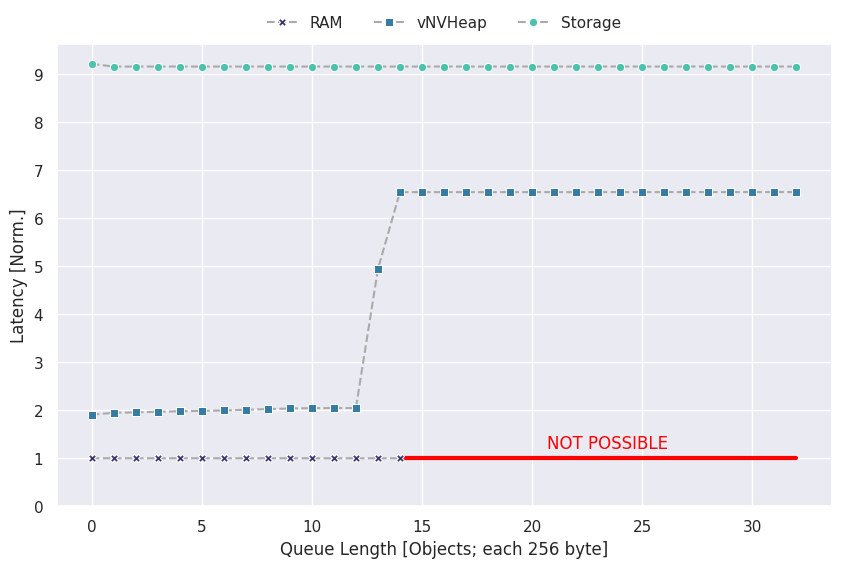

In [32]:
from util.plot import plot_lines
from util.convert import scale_data
import numpy as np

scale = 1
norm = True

impl_data = dataset[
    (dataset["benchmark_id"] == "event_queue")
    & (dataset["options.queue_length"] % scale == 0)
]

assert len(impl_data["options.buffer_size"].unique()) == 1
assert len(impl_data["options.ram_overhead"].unique()) == 1

max_buffer_size = (
    impl_data["options.buffer_size"][0] + impl_data["options.ram_overhead"][0]
)
print("Max buffer size:", max_buffer_size)

ram_data = dataset[
    (dataset["benchmark_id"] == "event_queue_ram")
    & (dataset["options.queue_length"] % scale == 0)
]
ram_data = ram_data[
    (ram_data["options.buffer_size"] + ram_data["options.ram_overhead"])
    <= max_buffer_size
]

plot_data = [
    {
        "name": "RAM",
        "x": "options.queue_length",
        "y": "mean",
        "marker": "X",
        "data": ram_data,
    },
    {
        "name": "vNVHeap",
        "x": "options.queue_length",
        "y": "mean",
        "marker": "s",
        "data": impl_data,
    },
    {
        "name": "Storage",
        "x": "options.queue_length",
        "y": "mean",
        "marker": "o",
        "data": dataset[
            (dataset["benchmark_id"] == "event_queue_storage")
            & (dataset["options.queue_length"] % scale == 0)
        ],
    },
]

obj_size = dataset["options.object_size"].unique()[0]

norm_val = None
if norm:
    ram_data_tmp = scale_data(ram_data, unit)
    norm_val = ram_data_tmp["mean"].mean()

options = {
    "data": plot_data,
    "scale": unit,
    "x_label": f"Queue Length [Objects; each {obj_size} byte]",
    "y_label": f"Latency in {unit}" if not norm else "Latency [Norm.]",
    "norm": norm_val
}

ram_data_tmp = ram_data.copy()
ram_data_tmp = scale_data(ram_data, unit)

ax = plot_lines(options)
plot_y = ram_data_tmp.iloc[-1]["mean"]
if norm:
    plot_y /= norm_val

ax.plot(
    [
        ram_data_tmp["options.queue_length"].max(),
        impl_data["options.queue_length"].max(),
    ],
    [plot_y, plot_y],
    color="red",
    linewidth=3,
    zorder=1
)
text_x = (ram_data_tmp["options.queue_length"].max() + impl_data["options.queue_length"].max()) / 2
text_x = text_x - text_x*0.1
text_y = ram_data_tmp.iloc[-1]["mean"] + ram_data_tmp.iloc[-1]["mean"]*0.2
if norm:
    text_y /= norm_val

ax.text(text_x, text_y, "NOT POSSIBLE", color="red")

if norm:
    ax.set_ylim(bottom=0)

    major_ticks = np.arange(0, 10, 1)
    ax.set_yticks(major_ticks)